In [1]:
import torch
from PIL import Image
from torchvision.transforms import v2
import torchvision.transforms as v1
from torch import nn
import numpy as np
from tqdm import tqdm
import random
import os
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from surface_dice import SurfaceDiceMetric
import wandb
import albumentations as A

device = "cuda" if torch.cuda.is_available() else "cpu"
input_dir = "/kaggle/input/blood-vessel-segmentation/"
train_dir = input_dir + "train/"

# reproducibility
seed = 42
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
os.environ["PYTHONHASHSEED"] = str(seed)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Load data

### Dataset

In [2]:
class KidneyDataset(torch.utils.data.Dataset):
    def __init__(self, imgs_dir, msks_dir, slices_ids, transforms=None):
        self.imgs_dir = imgs_dir
        self.msks_dir = msks_dir
        self.slices_ids = slices_ids
        self.transforms = transforms

    def __len__(self):
        return len(self.slices_ids)

    def __getitem__(self, idx):
        slice_id = self.slices_ids[idx]
        img_path = self.imgs_dir + slice_id
        msk_path = self.msks_dir + slice_id

        img = Image.open(img_path)
        msk = Image.open(msk_path)
        img = np.array(img, dtype=np.float32)
        msk = np.array(msk)

        if self.transforms is not None:
            t = self.transforms(image=img, mask=msk)
            img = t["image"]
            msk = t["mask"]
            
        img = torch.from_numpy(img)[None, :]
        # msk = torch.as_tensor(msk, dtype=torch.float32)
        # img = img / img.max()
        # msk /= 255 

        return img, msk

In [3]:
patch_size = 224
imgs_dir = f"{train_dir}kidney_1_dense/images/"
msks_dir = f"{train_dir}kidney_1_dense/labels/"
slices_ids = sorted(os.listdir(imgs_dir))

transforms = A.Compose(
    [
        A.RandomCrop(patch_size, patch_size)
    ]
)

train_ds = KidneyDataset(
    imgs_dir=imgs_dir,
    msks_dir=msks_dir,
    slices_ids=slices_ids,
    transforms=transforms,
)

eval_ds = KidneyDataset(
    imgs_dir=imgs_dir,
    msks_dir=msks_dir,
    slices_ids=slices_ids,
)

print("Train Dataset length:", len(train_ds))
print("Eval Dataset length:", len(train_ds))


Train Dataset length: 2279
Eval Dataset length: 2279


In [4]:
train_dl = DataLoader(
    train_ds,
    batch_size=32,
    num_workers=os.cpu_count(),
    shuffle=False,
    persistent_workers=True
)

eval_dl = DataLoader(
    eval_ds,
    batch_size=32,
    num_workers=os.cpu_count(),
    shuffle=False,
    persistent_workers=True
)

print("Train DataLoader length:", len(train_dl))
print("Eval DataLoader length:", len(train_dl))

Train DataLoader length: 72
Eval DataLoader length: 72


In [5]:
x, y = next(iter(eval_dl))

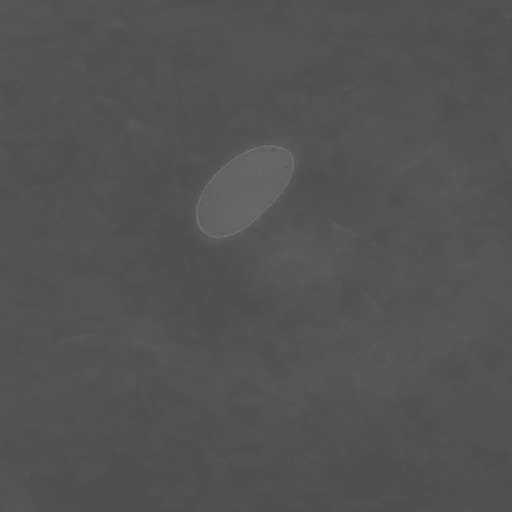

In [6]:
idx = 31
Image.fromarray(x[idx].squeeze().numpy().astype(np.uint16)).resize((512, 512))

In [7]:
print(x.shape)
print(x.dtype)

torch.Size([32, 1, 1303, 912])
torch.float32


In [8]:
h, w = x.shape[-2:]

overlap = 50
stride = patch_size - overlap

x = F.pad(
    x,
    (
        0, stride * ((w - patch_size) // stride + 1) + patch_size - w,
        0, stride * ((h - patch_size) // stride + 1) + patch_size - h
    ),
    mode="reflect"
)

h_pad, w_pad = x.shape[-2:]
print(h_pad, w_pad)

1442 920


In [9]:
unfold = torch.nn.Unfold(
    kernel_size=(patch_size, patch_size),
    stride=patch_size - overlap
)

fold = torch.nn.Fold(
    output_size=(h_pad, w_pad),
    kernel_size=(patch_size, patch_size),
    stride=patch_size - overlap
)



In [10]:
average_mask = (1 / fold(unfold(torch.ones(1, h_pad, w_pad))))
average_mask.shape

torch.Size([1, 1442, 920])

In [11]:
patches = unfold(x).view(32, patch_size, patch_size, -1).permute(0, 3, 1, 2)
patches.shape

torch.Size([32, 40, 224, 224])

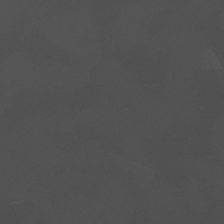

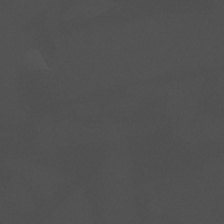

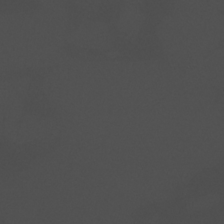

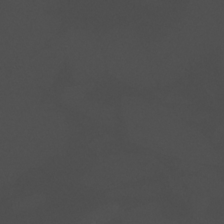

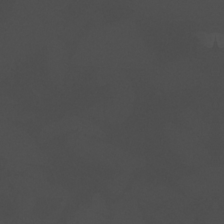

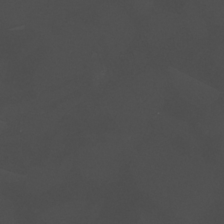

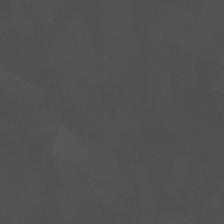

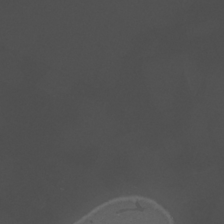

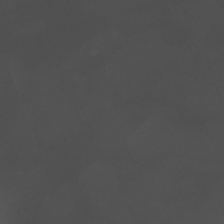

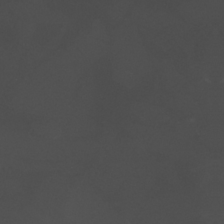

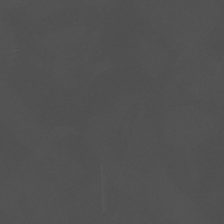

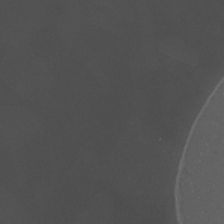

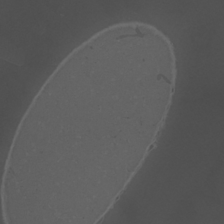

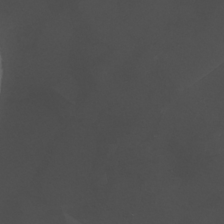

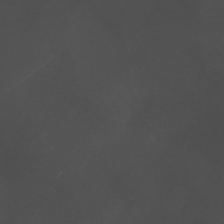

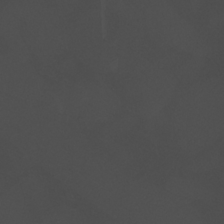

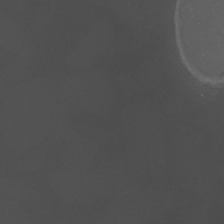

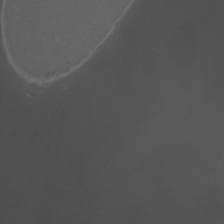

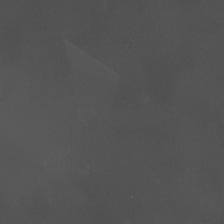

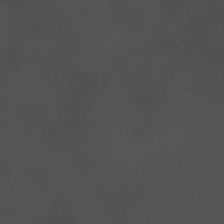

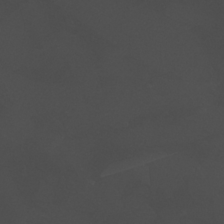

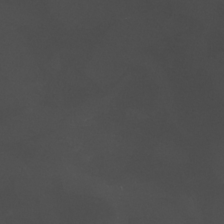

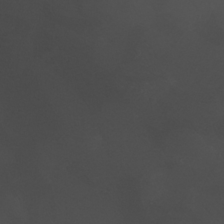

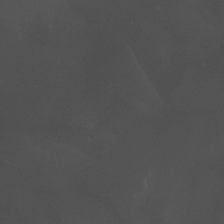

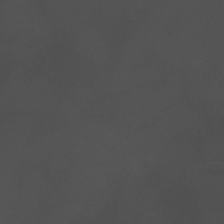

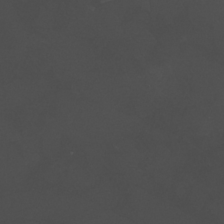

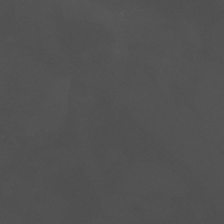

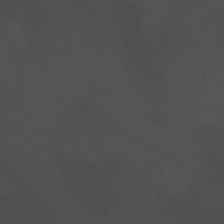

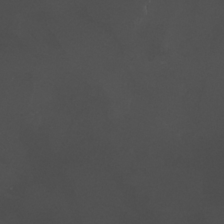

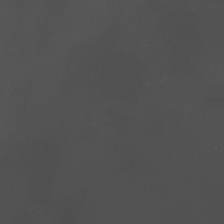

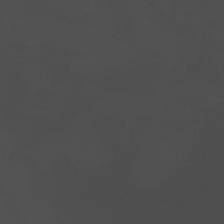

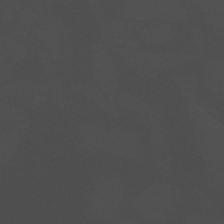

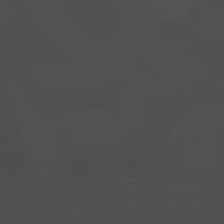

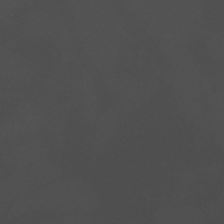

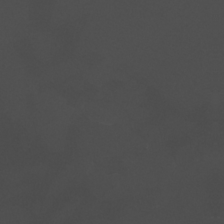

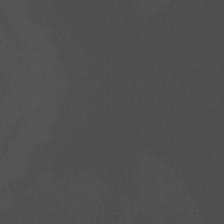

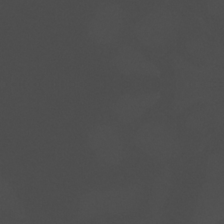

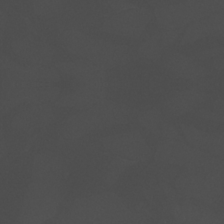

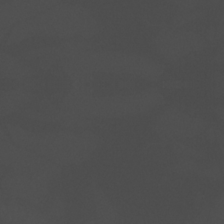

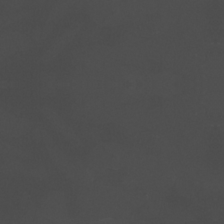

In [12]:
for i in range(40):
    display(Image.fromarray(patches[idx][i].numpy().astype(np.uint16)))

In [13]:
x_restored = fold(patches.permute(0, 2, 3, 1).view(32, patch_size * patch_size, -1))
x_restored = x_restored * average_mask
x_restored = x_restored[:, :, :h, :w]
x_restored.shape


torch.Size([32, 1, 1303, 912])

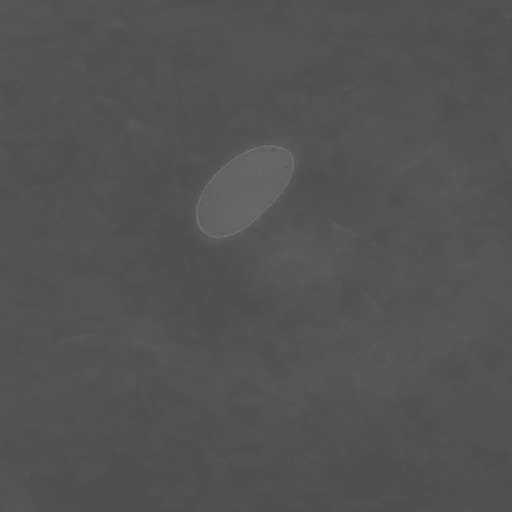

In [14]:
Image.fromarray(x_restored[idx].squeeze().numpy().astype(np.uint16)).resize((512, 512))